# Tarea 2 - Introducción a las Redes Neuronales y Deep Learning

**Nombre:** Bruno Morici

**ROL USM:** 202373555-8

**Curso:** INF395, Introducción a las Redes Neuronales y Deep Learning

**Profesor:** Alejandro Veloz

**Fecha:** 21/10/2025

# Parte 1: Desbalance de clases

### Pasos:
- Se hará uso de un dataset de clasificación de imágenes
- Artificialmente se limitarán las muestras de una clase para generar un desbalance artificial
- Se creará y entrenará un modelo FANN con las muestras totales
- Luego se harán predicciones midiendo el Acuraccy y el F1-Score (sobre todo en la clase desbalanceada, donde se espera sea cercano a cero)
- Luego se aplicará el método de Data Augmentation, para tomar las pocas muestras de la clase desbalanceada y balancearla a la par de las otras
- Finalmente se reentrenará el modelo, realizando nuevas predicciones y mediciones, para ver el efecto del método de rebalanceamiento.

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from collections import Counter

In [36]:
# Carga del dataset, creamos conjuntos de entrenamiento y prueba
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalización de los datos
train_images = train_images / 255.0
test_images = test_images / 255.0

# Definimos los nombres de las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [37]:
minority_class = 4  # Desbalanceamos la clase "Coat"

minority_idx = np.where(train_labels == minority_class)[0]
majority_idx = np.where(train_labels != minority_class)[0]

np.random.seed(42)
minority_idx_reduced = np.random.choice(minority_idx, 100, replace=False)

new_train_idx = np.concatenate([minority_idx_reduced, majority_idx])
train_images_ds = train_images[new_train_idx] # Nuevo dataset de entrenamiento desbalanceado
train_labels_ds = train_labels[new_train_idx] # Nuevas etiquetas de entrenamiento desbalanceadas

print("Cantidad de imágenes desbalanceadas por clase:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_ds==i).sum()}")



Cantidad de imágenes desbalanceadas por clase:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 100
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


In [38]:
# Creamos el modelo de arquitectura estándar con capas de neuronas mediante Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

### 1.1 - Modelo desbalanceado
Modelo con solo 100 muestras de la clase "Coat"

In [39]:
# Fiteamos el modelo con el dataset desbalanceado
model_ds = create_model()
model_ds.fit(train_images_ds, train_labels_ds, epochs=10, verbose=2)

# Evaluamos el modelo desbalanceado
prob_model_ds = tf.keras.Sequential([model_ds, tf.keras.layers.Softmax()])
predictions_ds = np.argmax(prob_model_ds.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
mask = test_labels == minority_class
acc_ds = accuracy_score(test_labels[mask], predictions_ds[mask])
f1_ds = f1_score(test_labels[mask], predictions_ds[mask], average='macro')

# Resultados
print(f"Desbalanceado - Accuracy Coat: {acc_ds:.4f}, F1 Coat: {f1_ds:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1691/1691 - 4s - 3ms/step - accuracy: 0.8573 - loss: 0.4219
Epoch 2/10
1691/1691 - 5s - 3ms/step - accuracy: 0.8916 - loss: 0.3070
Epoch 3/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9019 - loss: 0.2716
Epoch 4/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9099 - loss: 0.2492
Epoch 5/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9147 - loss: 0.2328
Epoch 6/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9195 - loss: 0.2197
Epoch 7/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9221 - loss: 0.2087
Epoch 8/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9271 - loss: 0.1983
Epoch 9/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9291 - loss: 0.1901
Epoch 10/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9317 - loss: 0.1834
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Desbalanceado - Accuracy Coat: 0.0810, F1 Coat: 0.0214


Ejemplo de predicción para el Modelo Desbalanceado

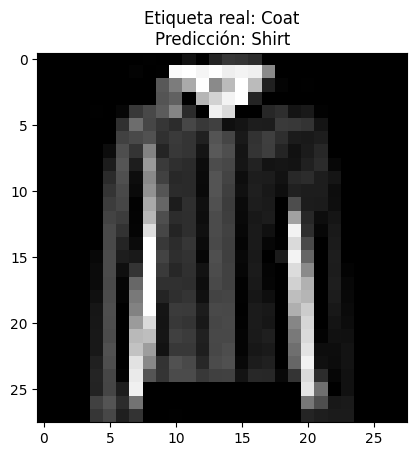

In [40]:
idx = np.where(test_labels==minority_class)[0][0]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_ds[idx]]}")
plt.show()

### 1.2 - Balanceo Artificial por remuestreo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se generaron rotaciones y modificaciones de altura y largo para modificar las muestras existentes y generar más.
- Se utiliza la técnica de remuestreo, mas puntualmente la de oversampling.

Balanceo por técnica de remuestreo oversampling

In [41]:
# Aumentación de datos para balancear la clase minoritaria
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Extraemos las imágenes y etiquetas de la clase minoritaria
minority_imgs = train_images_ds[train_labels_ds==minority_class]
minority_lbls = train_labels_ds[train_labels_ds==minority_class]

# Queremos igualar la cantidad de la clase minoritaria con la mayoría
majority_count = max([(train_labels_ds==i).sum() for i in range(10) if i!=minority_class])
n_needed = majority_count - len(minority_imgs)

aug_images, aug_labels = [], []

# Generamos imágenes aumentadas hasta alcanzar el balance
for x, y in zip(minority_imgs, minority_lbls):
    x = x.reshape((1,28,28,1))
    for batch in datagen.flow(x, batch_size=1):
        # Guardamos la imagen aumentada y su etiqueta
        aug_images.append(batch[0].reshape(28,28))
        aug_labels.append(y)
        if len(aug_images) >= n_needed:
            break
    if len(aug_images) >= n_needed:
        break

# Combinamos las imágenes aumentadas con el dataset desbalanceado
train_images_aug = np.concatenate([train_images_ds, np.array(aug_images)])
train_labels_aug = np.concatenate([train_labels_ds, np.array(aug_labels)])

print("Cantidad de imágenes después de balanceo artificial:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_aug==i).sum()}")


Cantidad de imágenes después de balanceo artificial:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


Creamos el modelo balanceado artificialmente

In [42]:
# Fiteamos el modelo con el dataset balanceado artificialmente
model_aug = create_model()
model_aug.fit(train_images_aug, train_labels_aug, epochs=10, verbose=2)

# Evaluamos el modelo balanceado artificialmente
prob_model_aug = tf.keras.Sequential([model_aug, tf.keras.layers.Softmax()])
predictions_aug = np.argmax(prob_model_aug.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
acc_aug = accuracy_score(test_labels[mask], predictions_aug[mask])
f1_aug = f1_score(test_labels[mask], predictions_aug[mask], average='macro')

# Resultados
print(f"Balanceado artificial - Accuracy Coat: {acc_aug:.4f}, F1 Coat: {f1_aug:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8695 - loss: 0.3914
Epoch 2/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9019 - loss: 0.2807
Epoch 3/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9099 - loss: 0.2496
Epoch 4/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9182 - loss: 0.2259
Epoch 5/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9216 - loss: 0.2119
Epoch 6/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9269 - loss: 0.2008
Epoch 7/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9287 - loss: 0.1915
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9327 - loss: 0.1794
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9359 - loss: 0.1730
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9385 - loss: 0.1642
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Balanceado artificial - Accuracy Coat: 0.2710, F1 Coat: 0.0711


Ejemplo de predicción con el Modelo Artificialmente Balanceado

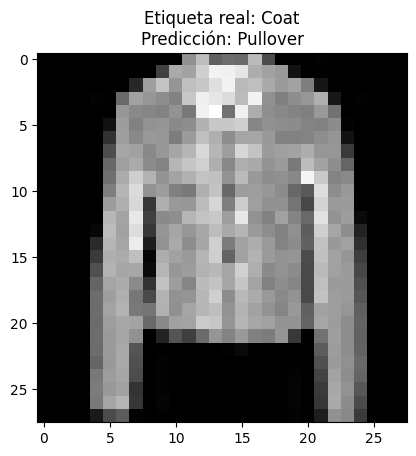

In [43]:
idx = np.where(test_labels==minority_class)[0][1]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_aug[idx]]}")
plt.show()

### 1.3 - Balanceo mediante modificación de la función objetivo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se penaliza más el error para la clase que posee menos muestras, en este caso "Coat".
- De esta forma el modelo compensa ese desbalance.
- No cambia el dataset, sino cómo el modelo aprende.

In [44]:
class_counts = Counter(train_labels_ds)
total_samples = len(train_labels_ds)
n_classes = len(class_counts)

# Si hay menos muestras de una clase, mayor será su peso
class_weight = {i: total_samples / (n_classes * class_counts[i]) for i in class_counts}

# Mostramos los pesos asignados por clase
print("Pesos asignados por clase:")
for i in range(10):
    print(f"{class_names[i]}: {class_weight[i]:.3f}")

Pesos asignados por clase:
T-shirt/top: 0.902
Trouser: 0.902
Pullover: 0.902
Dress: 0.902
Coat: 54.100
Sandal: 0.902
Shirt: 0.902
Sneaker: 0.902
Bag: 0.902
Ankle boot: 0.902


In [45]:
# Fiteamos el modelo con class_weight
model_weighted = create_model()
history_weighted = model_weighted.fit(train_images_ds, train_labels_ds,
                                      epochs=10, batch_size=64, verbose=0,
                                      validation_split=0.2,
                                      class_weight=class_weight)

# Evaluamos el modelo con class_weight
y_pred_w = np.argmax(model_weighted.predict(test_images), axis=1)
report_w = classification_report(test_labels, y_pred_w, output_dict=True)

mask = test_labels == minority_class
acc_wgt = accuracy_score(test_labels[mask], y_pred_w[mask])
f1_wgt = f1_score(test_labels[mask], y_pred_w[mask], average='macro')

# Resultados
print("\n--- Métricas para clase 'Coat' (con class_weight) ---")
print(f"Accuracy (Coat): {acc_wgt:.4f}")
print(f"F1-score (Coat): {f1_wgt:.4f}")

c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

--- Métricas para clase 'Coat' (con class_weight) ---
Accuracy (Coat): 0.6610
F1-score (Coat): 0.1137


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


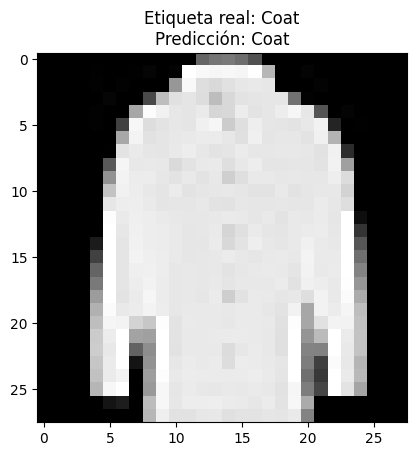

In [46]:
idx = np.where(test_labels == minority_class)[0][2]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


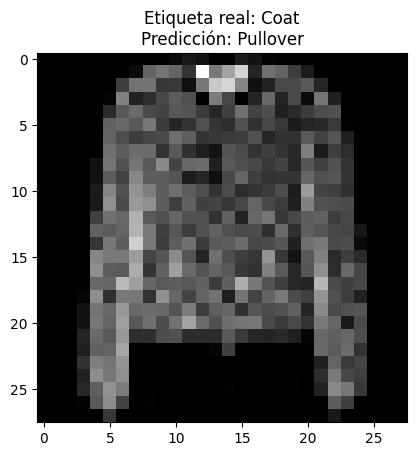

In [47]:
idx = np.where(test_labels == minority_class)[0][6]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

### 1.4 - Modelo balanceado original
Dataset completo, sin crear recortes artificiales, éste se encuentra balanceado desde el inicio

In [48]:
model_bal = create_model()
model_bal.fit(train_images, train_labels, epochs=10, verbose=2)

prob_model_bal = tf.keras.Sequential([model_bal, tf.keras.layers.Softmax()])
predictions_bal = np.argmax(prob_model_bal.predict(test_images), axis=1)

acc_bal = accuracy_score(test_labels[mask], predictions_bal[mask])
f1_bal = f1_score(test_labels[mask], predictions_bal[mask], average='macro')
print(f"Balanceado original - Accuracy Coat: {acc_bal:.4f}, F1 Coat: {f1_bal:.4f}")



Epoch 1/10


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 - 4s - 2ms/step - accuracy: 0.8245 - loss: 0.4967
Epoch 2/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8630 - loss: 0.3776
Epoch 3/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8760 - loss: 0.3392
Epoch 4/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8842 - loss: 0.3142
Epoch 5/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8918 - loss: 0.2937
Epoch 6/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8961 - loss: 0.2815
Epoch 7/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9000 - loss: 0.2685
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9040 - loss: 0.2571
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9078 - loss: 0.2473
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9110 - loss: 0.2399
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Balanceado original - Accuracy Coat: 0.7780, F1 Coat: 0.1750


Ejemplo de predicción con el Modelo Balanceado Original

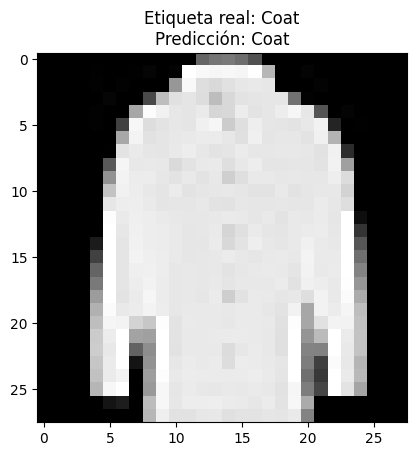

In [49]:
idx = np.where(test_labels==minority_class)[0][2]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_bal[idx]]}")
plt.show()

### 1.5 - Comparación final de los 4 modelos

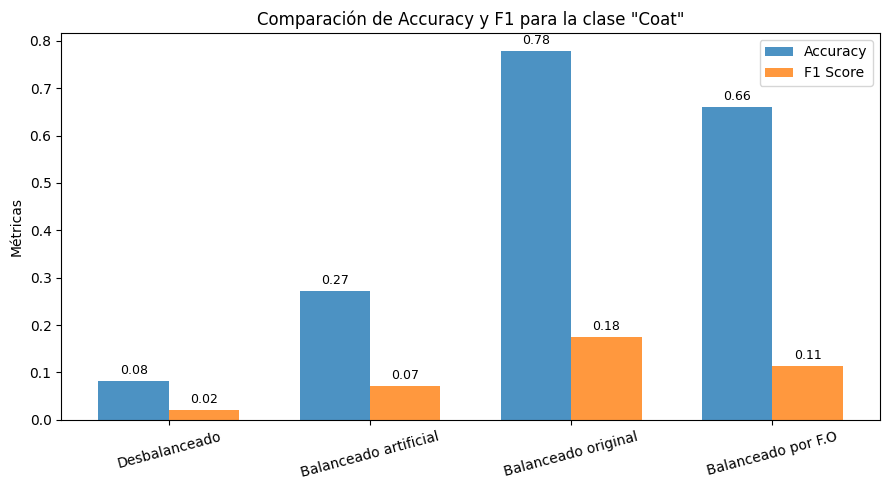

In [50]:
# Nombres de los modelos
models = [
    'Desbalanceado',
    'Balanceado artificial',
    'Balanceado original',
    'Balanceado por F.O'
]

# Métricas obtenidas (rellena con tus valores reales)
acc_values = [acc_ds, acc_aug, acc_bal, acc_wgt]
f1_values = [f1_ds, f1_aug, f1_bal, f1_wgt]

# Configuración de posiciones y ancho de barras
x = np.arange(len(models))
width = 0.35

# Crear figura
fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - width/2, acc_values, width, label='Accuracy', alpha=0.8)
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score', alpha=0.8)

# Etiquetas y título
ax.set_ylabel('Métricas')
ax.set_title('Comparación de Accuracy y F1 para la clase "Coat"')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Mostrar valores encima de cada barra
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Parte 2: Sistema de recomendación

### Parte 2.1: Reproducir ejemplo en PyTorch

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from zipfile import ZipFile
from urllib.request import urlretrieve

import pandas as pd

from sklearn.model_selection import train_test_split


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not os.path.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not os.path.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [52]:
raw_ratings = pd.read_csv(os.path.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Text(0, 0.5, 'Number of users')

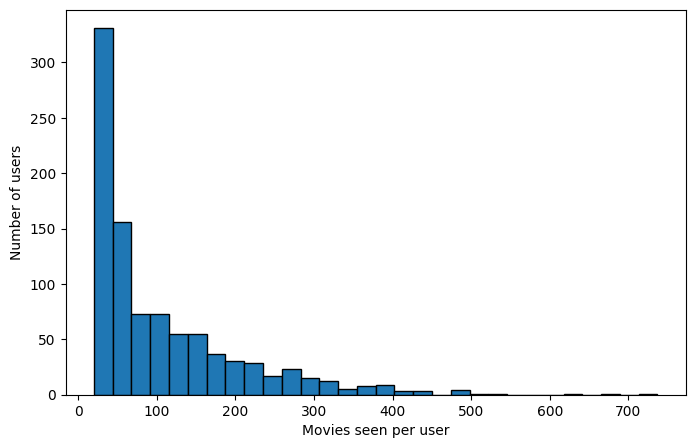

In [53]:
# Cuantas peliculas ha visto cada usuario
user_movie_counts = raw_ratings.groupby('user_id')['item_id'].nunique()

plt.figure(figsize=(8, 5))
plt.hist(user_movie_counts, bins=30, edgecolor='black')
plt.xlabel('Movies seen per user')
plt.ylabel('Number of users')

El archivo de metadatos contiene información como el nombre de la película o la fecha en que fue estrenada.

In [54]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(os.path.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


array([[<Axes: title={'center': 'release_year'}>]], dtype=object)

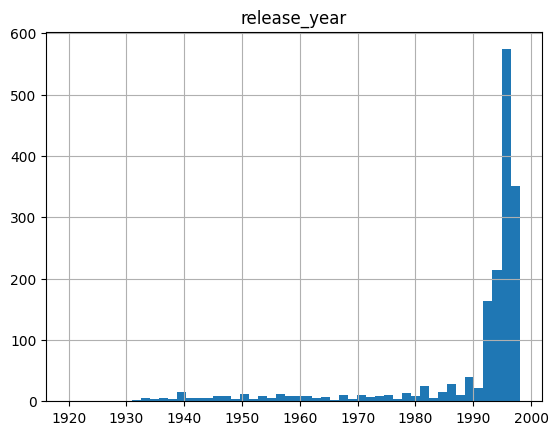

In [55]:
# Extraemos el año de lanzamiento de la película

def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50)

Complemento de los datos originales con los metadatos. Ahora existe duplicidad en los títulos, ya que se repite el dato del título para cada "rating"

In [56]:
all_ratings = pd.merge(items, raw_ratings)
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


In [57]:
# Estadisticas sobre todos los ratings
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Se calcula la popularidad de cada película en función de la cantidad de ratings que ha recibido. Luego, se combinan estos datos con la información de las películas para identificar las 10 películas más populares.

In [58]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [59]:
items["title"][49]

'Star Wars (1977)'

In [60]:
indexed_items = items.set_index('item_id')
indexed_items["title"][50]

'Star Wars (1977)'

In [61]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,0.0,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,NaN,1987.950100,462.48475,3.529860,8.835289e+08
std,330.798356,121.784558,NaN,14.169558,266.61442,1.125674,5.343856e+06
min,1.000000,1.000000,NaN,1920.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


In [62]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


Dividimos el dataset en entrenamiento y testeo

In [63]:
# Dividimos el dataset
ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

# Preparación de los datos para el modelo
user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

# Datos de prueba
user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

#### Creamos el modelo de retroalimentación explítica: Predicción de calificaciones supervisada con PyTorch
Para cada par de (usuario, ítem) se intenta predecir la calificación que el usuario daría al ítem.

### Parte 2.2: Transformarlo en un problema de clasificación